For the expanded tokenizers, generate the datasets first with: 

'python3 dataset_preprocess.py expanded'


# DistilRoBERTa confusion matrix


## Fine-tuned

### Tokenizer without an expanded vocabulary

/home/blanca/miniconda3/envs/thesis2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


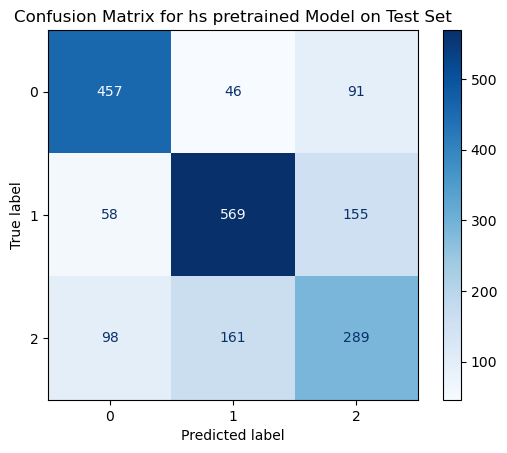

{'LAST EVAL/loss': 1.1017451177648736, 'LAST EVAL/accuracy': 0.6834719334719335, 'LAST EVAL/precision': 0.6729827349333034, 'LAST EVAL/recall': 0.6747846718366503, 'LAST EVAL/f1': 0.673791892132454, 'epoch': 1}


In [1]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #machen uch accurac von sklearn

import shap
import torch
import joblib

def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader #just performing the mean of loss of the epoch 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})



encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.AutoTokenizer.from_pretrained('blancasavi/pretrained_fancysweep')
model = transformers.AutoModelForSequenceClassification.from_pretrained("blancasavi/pretrained_fancysweep",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 

dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/dataset_berta_basictokenizer')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


# EVALUATION ON TEST SET

model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        logits = outputs.logits
        
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for hs pretrained Model on Test Set")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    



### Tokenizer with an expanded vocabulary

#### Evaluation

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


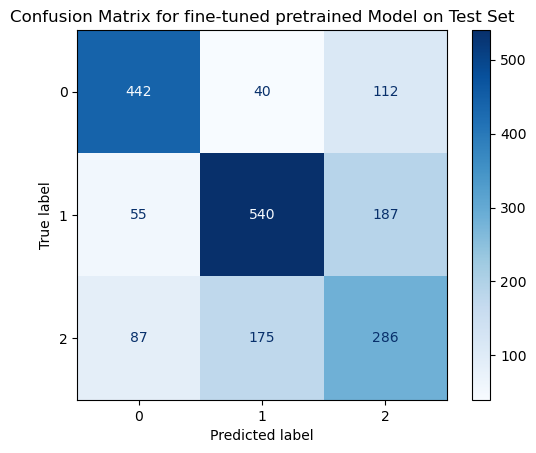

{'LAST EVAL/loss': 1.0117963210552066, 'LAST EVAL/accuracy': 0.659043659043659, 'LAST EVAL/precision': 0.6536566640122841, 'LAST EVAL/recall': 0.6521808795752331, 'LAST EVAL/f1': 0.6526487837689353, 'epoch': 1}


In [5]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #machen uch accurac von sklearn

import shap
import torch
import joblib


def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader #just performing the mean of loss of the epoch 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})




encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.AutoTokenizer.from_pretrained('blancasavi/pretrained_light')
model = transformers.AutoModelForSequenceClassification.from_pretrained("blancasavi/pretrained_light",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 


dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/dataset_light')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        logits = outputs.logits
        
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for fine-tuned pretrained Model on Test Set")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    

## Not fine-tuned

#### Evaluation

/home/blanca/miniconda3/envs/thesis2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


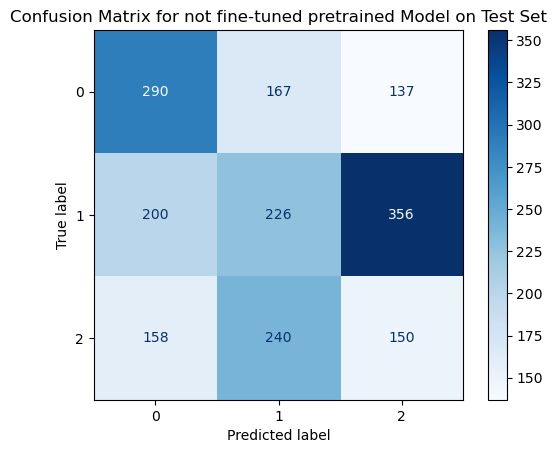

{'LAST EVAL/loss': 4.219164936003349, 'LAST EVAL/accuracy': 0.34615384615384615, 'LAST EVAL/precision': 0.3459474576656248, 'LAST EVAL/recall': 0.3503135578324905, 'LAST EVAL/f1': 0.3461041751997671, 'epoch': 1}


In [9]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #machen uch accurac von sklearn

import shap
import torch
import joblib



def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})

encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.AutoTokenizer.from_pretrained('badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification')
model = transformers.AutoModelForSequenceClassification.from_pretrained("badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 

dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/dataset_berta_basictokenizer')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


# EVALUATION ON TEST SET

model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        # We don't need gradients for validating
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        # Logits act as predictions
        logits = outputs.logits
        
        # Calculating total batch loss using the logits and labels
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for not fine-tuned pretrained Model on Test Set")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    

# Bbase confusion matrix

## Fine-tuned

### Tokenizer without an expanded vocabulary

#### Evaluation

/home/blanca/miniconda3/envs/thesis2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


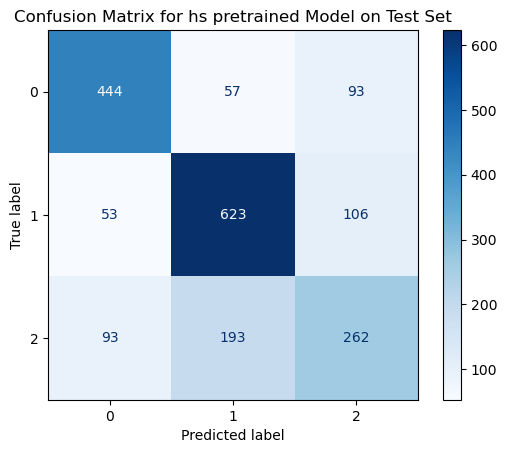

{'LAST EVAL/loss': 0.9717170324377499, 'LAST EVAL/accuracy': 0.6907484407484408, 'LAST EVAL/precision': 0.6781677492719401, 'LAST EVAL/recall': 0.6740840430238754, 'LAST EVAL/f1': 0.6740653853485797, 'epoch': 1}


In [2]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 

import shap
import torch
import joblib

def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})


encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.BertTokenizer.from_pretrained('blancasavi/bert_base_pious')
model = transformers.AutoModelForSequenceClassification.from_pretrained("blancasavi/bert_base_pious",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 


dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/fixed_dataset_bb_basetokenizer')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


# EVALUATION ON TEST SET

model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        # We don't need gradients for validating
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        # Logits act as predictions
        logits = outputs.logits
        
        # Calculating total batch loss using the logits and labels
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for hs pretrained Model on Test Set")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    



### Tokenizer with an expanded vocabulary

#### Evaluation

/home/blanca/miniconda3/envs/thesis2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


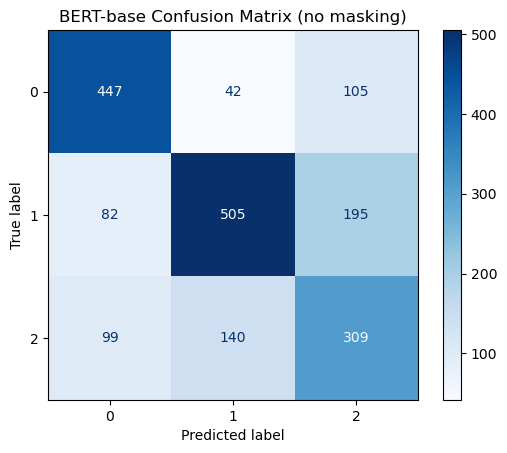

{'LAST EVAL/loss': 1.8104473503182847, 'LAST EVAL/accuracy': 0.6554054054054054, 'LAST EVAL/precision': 0.6514175534253951, 'LAST EVAL/recall': 0.6540579722716112, 'LAST EVAL/f1': 0.6510900415368353, 'epoch': 1}


In [18]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #machen uch accurac von sklearn

import shap
import torch
import joblib


def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader #just performing the mean of loss of the epoch 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})


def plot_confusion_matrix(conf_matrix, labels, word):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix after masking {word} on Test Set")  
    plt.show()


encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.BertTokenizer.from_pretrained('blancasavi/bbase_sandy')
model = transformers.AutoModelForSequenceClassification.from_pretrained("blancasavi/bbase_sandy",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 


dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/dataset_sandy')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


# EVALUATION ON TEST SET

model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        logits = outputs.logits
        
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("BERT-base Confusion Matrix (no masking)")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    


## Not fine-tuned

There is a random factor as the result changes for every evaluation

#### Evaluation

/home/blanca/miniconda3/envs/thesis2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


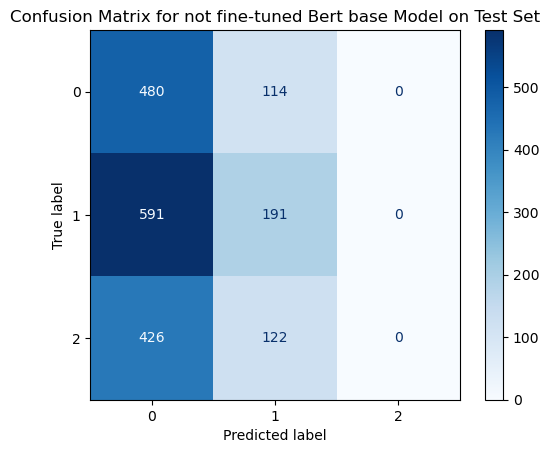

{'LAST EVAL/loss': 1.0993418436327416, 'LAST EVAL/accuracy': 0.34875259875259873, 'LAST EVAL/precision': 0.2559826913780723, 'LAST EVAL/recall': 0.35077544412582773, 'LAST EVAL/f1': 0.25835802658128754, 'epoch': 1}


In [15]:
import datasets
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk, Dataset, ClassLabel, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #machen uch accurac von sklearn

import shap
import torch
import joblib



def collate_pad(data_collate):
  input_ids_batch = []
  attention_mask_batch = []
  labels_batch = []
  for i in range(len(data_collate)):
    input_ids_batch.append(torch.tensor(data_collate[i]['input_ids']).squeeze())
    attention_mask_batch.append(torch.tensor(data_collate[i]['attention_mask']).squeeze())
    labels_batch.append(torch.tensor(data_collate[i]['final_label']).unsqueeze(0)) 
  
  input_ids_batch = torch.nn.utils.rnn.pad_sequence(input_ids_batch, batch_first=True, padding_value=0)
  attention_mask_batch = torch.nn.utils.rnn.pad_sequence(attention_mask_batch, batch_first=True, padding_value=0)
  labels_batch = torch.nn.utils.rnn.pad_sequence(labels_batch, batch_first=True)
  
  return{
    'input_ids': input_ids_batch,
    'attention_mask': attention_mask_batch,
    'labels': labels_batch       
} 


def metrics_log(all_labels, all_predictions, epoch_loss, len_loader, epoch, mode):
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss /= len_loader 

    print({f"{mode}/loss": epoch_loss, 
               f"{mode}/accuracy": accuracy,
               f"{mode}/precision": precision,
               f"{mode}/recall": recall,
               f"{mode}/f1": f1,
               "epoch": epoch + 1})

encoder = LabelEncoder()
encoder.classes_ = np.load('/home/blanca/Documents/Thesis_Code/Dataset/classes.npy',allow_pickle=True)
id2label = {idx: label for idx, label in enumerate(encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = transformers.AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",num_labels=len(encoder.classes_), id2label=id2label, label2id=label2id).cuda()
loss_fn = torch.nn.CrossEntropyLoss() 

dataset = load_from_disk('/home/blanca/Documents/Thesis_Code/code/saved_datasets/fixed_dataset_bb_basetokenizer')
dataset = dataset["test"]
batch_size=8
test_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_pad)


# EVALUATION ON TEST SET

model.eval()
epoch_test_loss=0
test_all_labels = []
test_all_predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids = inputs, labels=labels, attention_mask=attention_mask)
        
        # Logits act as predictions
        logits = outputs.logits
        
        # Calculating total batch loss using the logits and labels
        loss = loss_fn(logits, labels.squeeze())
        epoch_test_loss += loss.item()
        
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(logits.argmax(1).cpu().numpy())


conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for not fine-tuned Bert base Model on Test Set")
plt.show()

metrics_log(test_all_labels, test_all_predictions, epoch_test_loss, len(test_loader), 0, "LAST EVAL")
    